In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from corpus_reader import CHILDESCorpusReader

corpus_root = nltk.data.find('corpora')
brown = CHILDESCorpusReader(corpus_root, 'childes/data-xml/Eng-USA/Brown/.*.xml')
adam_dlgs = [fileID for fileID in brown.fileids() if 'Adam' in fileID]

In [2]:
def nansem(samples):
    """
    Estimated standard error of the mean
    = (standard deviation / sqrt(sample size)),
    with NaN values ignored.
    """
    return np.nanstd(samples) / np.sqrt(len(samples))

## Measures

### Complexity measures
Two very simple complexity measures are defined below.

In [3]:
def dlg_mul(dlg_sents):
    """
    Mean number of words in utterances.
    """
    # TODO ignore words that are repetitions from previous utterance
    
    # compute utterance length for all utterances
    utt_mul = [[spkID, len(sent)] for spkID, sent in dlg_sents]
    
    # combine utterances into turns
    turn_mul = turns(utt_mul)
        
    # return mean over utterances in turn
    return [[spkID, np.mean(muls)] for spkID, muls in turn_mul]

def dlg_mwl(dlg_sents):
    """
    Mean length of words in utterances.
    """
    # TODO ignore words that are repetitions from previous utterance
    utt_mwl = [[spkID, np.mean([len(w) for w in sent])] 
               if len(sent) > 0 else [spkID, np.nan]
               for spkID, sent in dlg_sents]

    # combine utterances into turns
    turn_mwl = turns(utt_mwl)
    
    return [[spkID, np.mean(mwls)] for spkID, mwls in turn_mwl]

### Alignment measures

In [4]:
def shared_unigrams(turns):
    None #TODO

## Extracting turns from dialogues & creating matrices
Following follows Fernandez & Grimm (2014): "We consider a turn to be a stretch of speech by one speaker, which may include more than one utterance".

For alignment measures, the alignment between turns is plotted in the recurrence matrix.

For complexity measures, the difference between turns* in complexity is plotted in the recurrence matrix.

(* subtraction: child's turn - mother's turn, may be negative; should we do absolute difference?)

In [5]:
def turns(utt_measures):
    """
    Aggregate per-utterance measures into turns.
    """
    turns = []
    
    # go over every utterance
    for i, (spk, ms) in enumerate(utt_measures):
        
        # check the speaker of the previous turn
        prev_spk = utt_measures[i-1][0] if i > 0 else None
        
        # if the previous utterance had the same
        # speaker as the current utterance, add
        # to the same turn
        if spk == prev_spk:
            turns[-1][1].append(ms)
        else:
            turns.append([spk, [ms]])
    return turns

def turn_pairs(turn_measures):
    """
    This extracts sequential (ADT, CHI) pairs from the dialogue, 
    to compute the recurrence plot measures over.
    
    Note: includes investigator turns!
    """
    turn_pairs = []
    for i, turn in enumerate(turn_measures[:-1]):
        if turn[0] != 'CHI' and turn_measures[i+1][0] == 'CHI':
            turn_pairs.append([turn, turn_measures[i+1]])
    return turn_pairs

def diff_matrix(turn_pairs):
    """
    This computes the differences in any given measure between 
    turn i (ADT) and turn j (CHI), and puts them in a matrix.
    """
    n = len(turn_pairs)
            
    # child
    m_turns_j = np.repeat(np.array(turn_pairs)[:,1,1].astype(float), n)
    # adult
    m_turns_i = np.tile(np.array(turn_pairs)[:,0,1].astype(float), n)
    # differences
    diff_vec = m_turns_j - m_turns_i
    
    # adult should be on x-axis of this matrix, child on y-axis
    diff_mat = diff_vec.reshape(n,n)
            
    return diff_mat

### Global & local rates

In [6]:
def global_rate(matrix):
    return np.nanmean(matrix)

def local_rate(matrix, d, subset=None):
    """
    This should be RR_d
    """
    # we go over the diagonal of the matrix
    # i.e. consider all points (i, j) where i == j
    # and then we also take the points that are
    # d steps away (above or below) from the diagonal,
    # i.e. from (j, i-d) to (j, i+d)
    # over all those points, we take the mean
    
    # i is i-th turn by participant on the x-axis (adult)
    # j is j-th turn by participant on the y-axis (child)
    
    n = len(matrix)
    
    D = []
    
    # iterate over the diagonal
    for i, j in zip(range(n), range(n)):
        # only consider points where j > i
        if subset == 'pos':
            if i < d:
                D.extend(matrix[j, :i])
            else:
                D.extend(matrix[j, i-d:i])
            
        # only consider points where i > j
        elif subset == 'neg':
            if i < d:
                D.extend(matrix[j, i+1:i+1+d])
            else:
                D.extend(matrix[j, i+1:i+1+d])
            
        # consider points in both directions
        else:
            if i < d:
                D.extend(matrix[j, :i+d+1])
            else:
                D.extend(matrix[j, i-d:i+d+1])
    
    print(D)
    return np.mean(D)

## Plots for Adam dialogues

In [7]:
ages = []

mwl_chi = []
mwl_adt = []
mwl_rates = []

mul_chi = []
mul_adt = []
mul_rates = []

for dlg_file in adam_dlgs:
    dlg_sents = brown.sents(dlg_file)
    age = brown.age(dlg_file, month=True)
    ages.append(age)
    
    dlg_mwordlen = dlg_mwl(dlg_sents)
    chi_mwordlen = [utt[1] for utt in dlg_mwordlen 
                    if utt[0] == 'CHI']
    adt_mwordlen = [utt[1] for utt in dlg_mwordlen 
                    if utt[0] != 'CHI']
    mwl_chi.append((np.nanmean(chi_mwordlen), nansem(chi_mwordlen)))
    mwl_adt.append((np.nanmean(adt_mwordlen), nansem(adt_mwordlen)))
    
    dlg_muttlen = dlg_mul(dlg_sents)
    chi_muttlen = [utt[1] for utt in dlg_muttlen 
                    if utt[0] == 'CHI']
    adt_muttlen = [utt[1] for utt in dlg_muttlen 
                    if utt[0] != 'CHI']
    mul_chi.append((np.nanmean(chi_muttlen), nansem(chi_muttlen)))
    mul_adt.append((np.nanmean(adt_muttlen), nansem(adt_muttlen)))    
    
    mwl_rec_mat = diff_matrix(turn_pairs(dlg_mwl(dlg_sents)))
    mul_rec_mat = diff_matrix(turn_pairs(dlg_mul(dlg_sents)))
    
    mwl_rates.append(global_rate(mwl_rec_mat))
    mul_rates.append(global_rate(mul_rec_mat))
    
#     print('AGE:', age)
#     print('MWL CHI:', mwl_chi[-1], 'MWL ADT:', mwl_adt[-1])
#     plt.imshow(mwl_rec_mat)
#     plt.colorbar()
#     plt.gca().invert_yaxis()
#     plt.title('Mean word length')
#     plt.xlabel('adult turns')
#     plt.ylabel('child turns')
#     plt.show()
    
#     print('MUL CHI:', mul_chi[-1], 'MUL ADT:', mul_adt[-1])
#     plt.imshow(mul_rec_mat)
#     plt.colorbar()
#     plt.gca().invert_yaxis()
#     plt.title('Mean utterance length')
#     plt.xlabel('adult turns')
#     plt.ylabel('child turns')
#     plt.show()

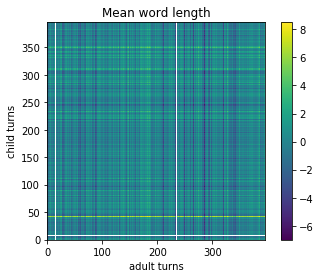

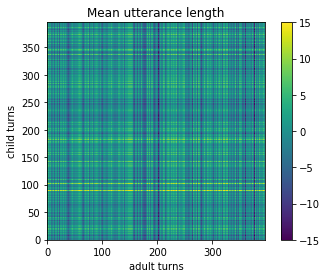

In [8]:
# recurrence plots for just Adam's last dialogue
plt.imshow(mwl_rec_mat)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Mean word length')
plt.xlabel('adult turns')
plt.ylabel('child turns')
plt.show()

plt.imshow(mul_rec_mat)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Mean utterance length')
plt.xlabel('adult turns')
plt.ylabel('child turns')
plt.show()

## Convergence in complexity (?)

### Averaged over all dialogues
(should resemble Fig. 2 from Kunert, Fernandez & Zuidema 2011)

(erhm, it looks a bit different -- should check differences in how we compute these measures)

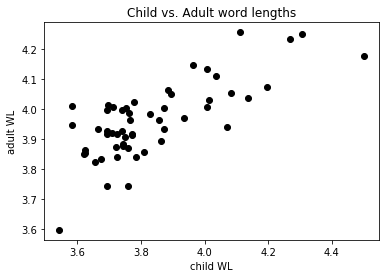

In [9]:
# plot child word lengths (x-axis) against adult word lengths (y-axis)
plt.plot(np.array(mwl_chi)[:,0], np.array(mwl_adt)[:,0], 'ko')
plt.xlabel('child WL')
plt.ylabel('adult WL')
plt.title('Child vs. Adult word lengths')
plt.show()

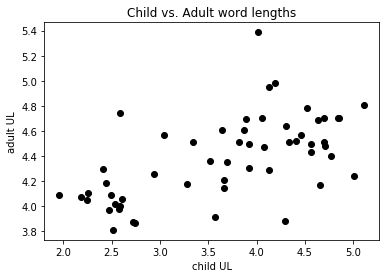

In [10]:
# plot child utt lengths (x-axis) against adult utt lengths (y-axis)
plt.plot(np.array(mul_chi)[:,0], np.array(mul_adt)[:,0], 'ko')
plt.xlabel('child UL')
plt.ylabel('adult UL')
plt.title('Child vs. Adult word lengths')
plt.show()

### Over time

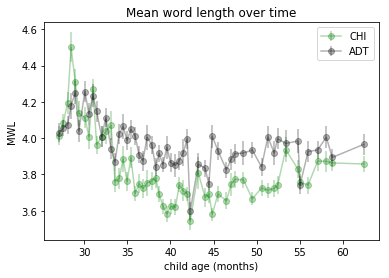

In [11]:
# plot mean word length over time for CHI and ADT
plt.errorbar(ages, np.array(mwl_chi)[:,0], 
             yerr=np.array(mwl_chi)[:,1],
             label='CHI', alpha=0.3, fmt='go-')
plt.errorbar(ages, np.array(mwl_adt)[:,0], 
             yerr=np.array(mwl_adt)[:,1], 
             label='ADT', alpha=0.3, fmt='ko-')
plt.legend()
plt.xlabel('child age (months)')
plt.ylabel('MWL')
plt.title('Mean word length over time')
plt.show()

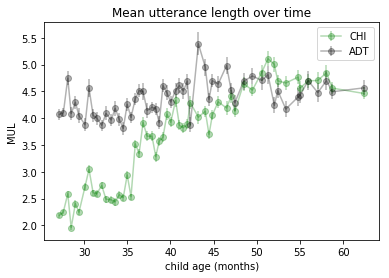

In [12]:
# plot mean utterance length over time for CHI and ADT
plt.errorbar(ages, np.array(mul_chi)[:,0], 
             yerr=np.array(mul_chi)[:,1],
             label='CHI', alpha=0.3, fmt='go-')
plt.errorbar(ages, np.array(mul_adt)[:,0], 
             yerr=np.array(mul_adt)[:,1], 
             label='ADT', alpha=0.3, fmt='ko-')
plt.legend()
plt.xlabel('child age (months)')
plt.ylabel('MUL')
plt.title('Mean utterance length over time')
plt.show()

### Global recurrence rate over time

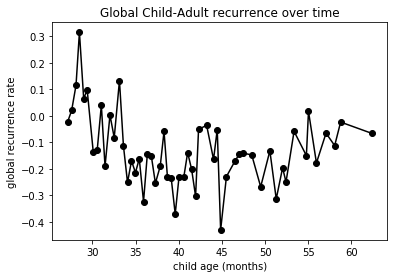

In [15]:
plt.plot(ages, mwl_rates, 'ko-')
plt.title('Global Child-Adult recurrence over time')
plt.xlabel('child age (months)')
plt.ylabel('global recurrence rate')
plt.show()

## Recurrence with alignment measures

### Cross-recurrence plot for a dialogue with lexeme unigrams

(something resembling Fig.1 from Fernandez & Grimm, 2014)

In [ ]:
# TODO

### Local RR for varying d
(something resembling Fig. 2 from Fernandez & Grimm 2014)

In [ ]:
# TODO